In [1]:
import os
os.environ["KMP_WARNINGS"] = "off"
import warnings
warnings.filterwarnings("ignore")

In [2]:
from pathlib import Path
import sys

sys.path.insert(1, str(Path().cwd().parent))
import common_config

In [3]:
common_config.figure_journal_basic()

In [4]:
import pertpy as pt
import scanpy as sc
import matplotlib.pyplot as plt
from adjustText import adjust_text
import matplotlib
import seaborn as sns

In [5]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [6]:
G1_CYCLE = [
    "CDKN1A",
    {"CDKN1B", "CDKN1A"},
    "CDKN1B",
    {"CDKN1C", "CDKN1A"},
    {"CDKN1C", "CDKN1B"},
    "CDKN1C",
]

ERYTHROID = [
    {"CBL", "CNN1"},
    {"CBL", "PTPN12"},
    {"CBL", "PTPN9"},
    {"CBL", "UBASH3B"},
    {"SAMD1", "PTPN12"},
    {"SAMD1", "UBASH3B"},
    {"UBASH3B", "CNN1"},
    {"UBASH3B", "PTPN12"},
    {"UBASH3B", "PTPN9"},
    {"UBASH3B", "UBASH3A"},
    {"UBASH3B", "ZBTB25"},
    {"BPGM", "SAMD1"},
    "PTPN1",
    {"PTPN12", "PTPN9"},
    {"PTPN12", "UBASH3A"},
    {"PTPN12", "ZBTB25"},
    {"UBASH3A", "CNN1"},
]

PIONEER_FACTORS = [
    {"FOXA1", "FOXF1"},
    {"FOXA1", "FOXL2"},
    {"FOXA1", "HOXB9"},
    {"FOXA3", "FOXA1"},
    {"FOXA3", "FOXF1"},
    {"FOXA3", "FOXL2"},
    {"FOXA3", "HOXB9"},
    "FOXA3",
    {"FOXF1", "FOXL2"},
    {"FOXF1", "HOXB9"},
    {"FOXL2", "MEIS1"},
    "HOXA13",
    "HOXC13",
    {"POU3F2", "FOXL2"},
    "TP73",
    "MIDN",
    {"LYL1", "IER5L"},
    "HOXC13",
    {"DUSP9", "SNAI1"},
    {"ZBTB10", "SNAI1"},
]

GRANULOCYTE_APOPTOSIS = [
    "SPI1",
    "CEBPA",
    {"CEBPB", "CEBPA"},
    "CEBPB",
    {"CEBPE", "CEBPA"},
    {"CEBPE", "CEBPB"},
    {"CEBPE", "RUNX1T1"},
    {"CEBPE", "SPI1"},
    "CEBPE",
    {"ETS2", "CEBPE"},
    {"KLF1", "CEBPA"},
    {"FOSB", "CEBPB"},
    {"FOSB", "CEBPE"},
    {"ZC3HAV1", "CEBPA"},
    {"JUN", "CEBPA"},
]

PRO_GROWTH = [
    {"CEBPE", "KLF1"},
    "KLF1",
    {"KLF1", "BAK1"},
    {"KLF1", "MAP2K6"},
    {"KLF1", "TGFBR2"},
    "ELMSAN1",
    {"MAP2K3", "SLC38A2"},
    {"MAP2K3", "ELMSAN1"},
    "MAP2K3",
    {"MAP2K3", "MAP2K6"},
    {"MAP2K6", "ELMSAN1"},
    "MAP2K6",
    {"MAP2K6", "KLF1"},
]

MEGAKARYOCYTE = [
    {"MAPK1", "TGFBR2"},
    "MAPK1",
    {"ETS2", "MAPK1"},
    "ETS2",
    {"CEBPB", "MAPK1"},
]

programmes = {
    "G1 cell cycle": G1_CYCLE,
    "Erythroid": ERYTHROID,
    "Pioneer factors": PIONEER_FACTORS,
    "Granulocyte apoptosis": GRANULOCYTE_APOPTOSIS,
    "Pro-growth": PRO_GROWTH,
    "Megakaryocyte": MEGAKARYOCYTE,
}

In [7]:
adata = sc.read_h5ad("norman/data/norman_preprocessed.h5ad")
adata.obs["guide_ids"] = adata.obs["guide_ids"].cat.rename_categories({"": "control"})
adata

AnnData object with n_obs × n_vars = 111255 × 4000
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'g

In [8]:
gene_programme = []

for target_pert in adata.obs["perturbation_name"]:
    if target_pert == "control":
        gene_programme.append("Control")
        continue

    found_programme = False
    for programme, pert_list in programmes.items():
        for pert in pert_list:
            if (type(pert) == set and pert == set(target_pert.split("+"))) or (
                target_pert == pert
            ):
                gene_programme.append(programme)
                found_programme = True
                break

    if not found_programme:
        gene_programme.append("Unknown")

adata.obs["gene_programme"] = gene_programme
adata.obs["gene_programme"] = adata.obs["gene_programme"].astype("category")

In [9]:
psadata_classifier = sc.read("norman/output/no_mixscape_psadata_classifier.h5ad")

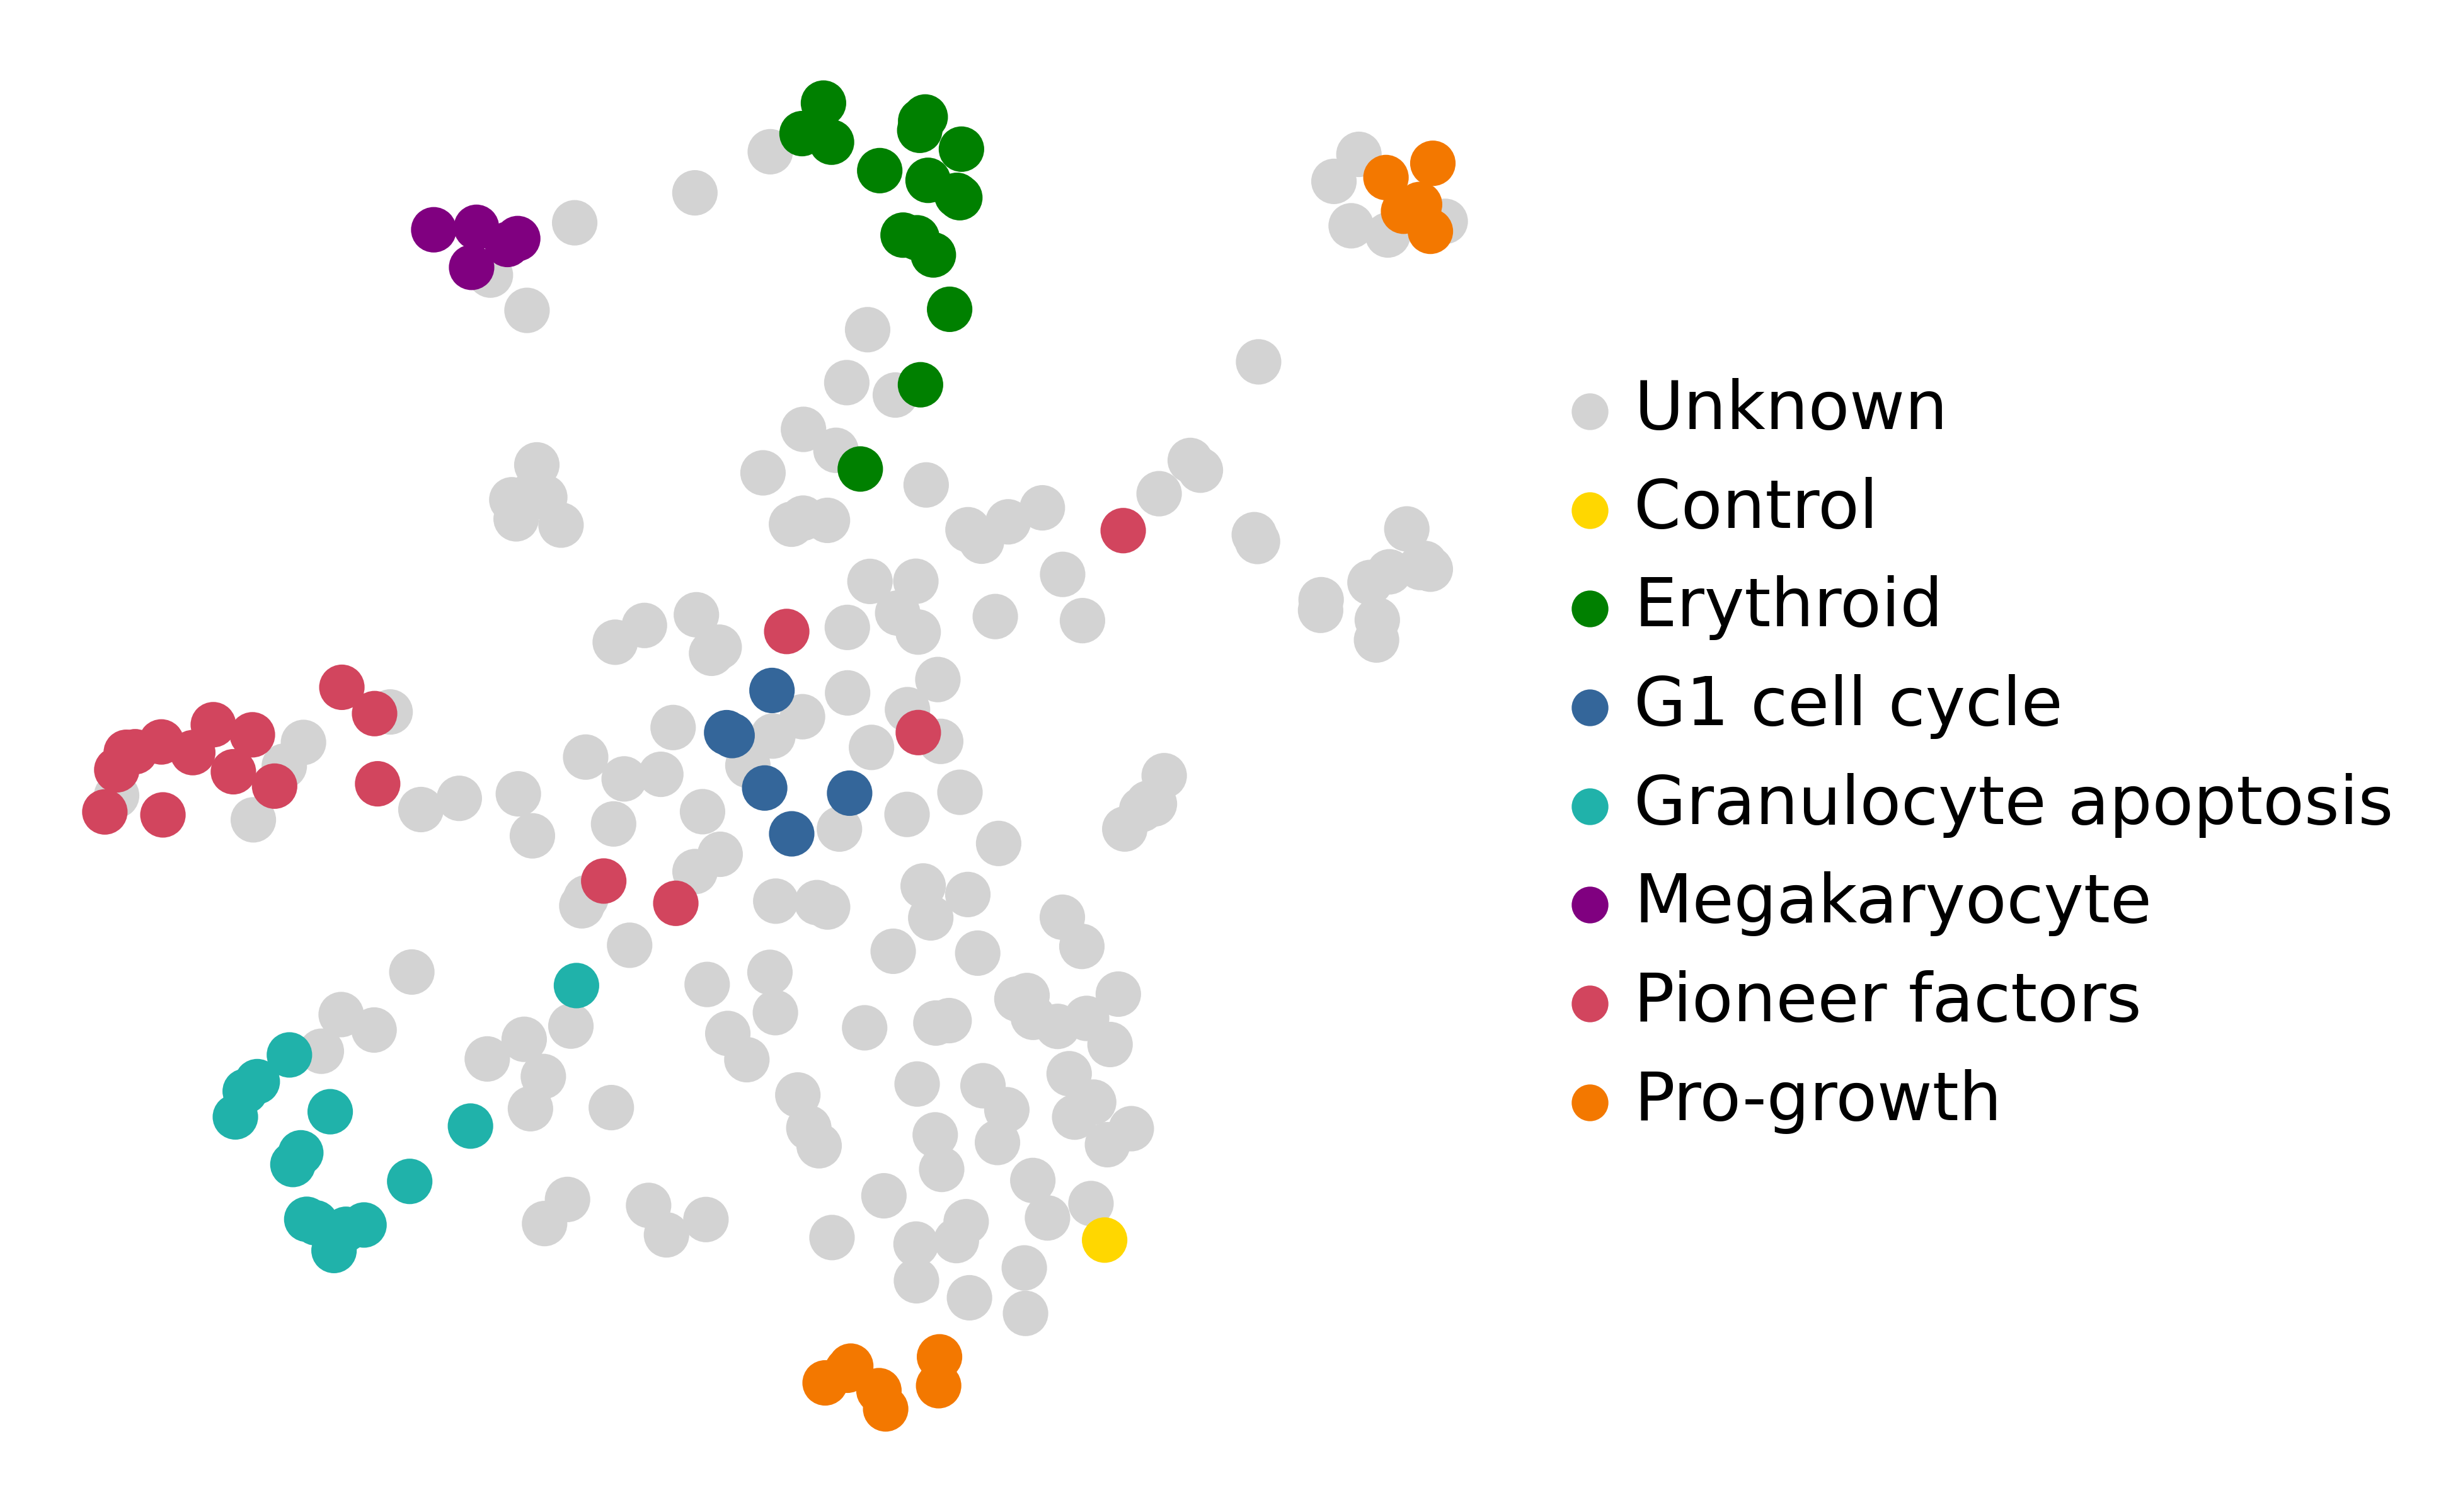

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
sc.pl.umap(psadata_classifier[psadata_classifier.obs["gene_programme"] == "Unknown"], 
           color="gene_programme", 
           show=False, 
           size=300, 
           ax=ax, 
           title = "",
           palette=common_config.norman_gene_program_color_map)

sc.pl.umap(psadata_classifier[psadata_classifier.obs["gene_programme"] != "Unknown"], 
           color="gene_programme", 
           show=False, 
           size=300, 
           ax=ax, 
           title = "",
           palette=common_config.norman_gene_program_color_map)

plt.savefig("norman/figures/no_mix_discriminator_gene_programme_basic_UMAP.png", bbox_inches="tight")

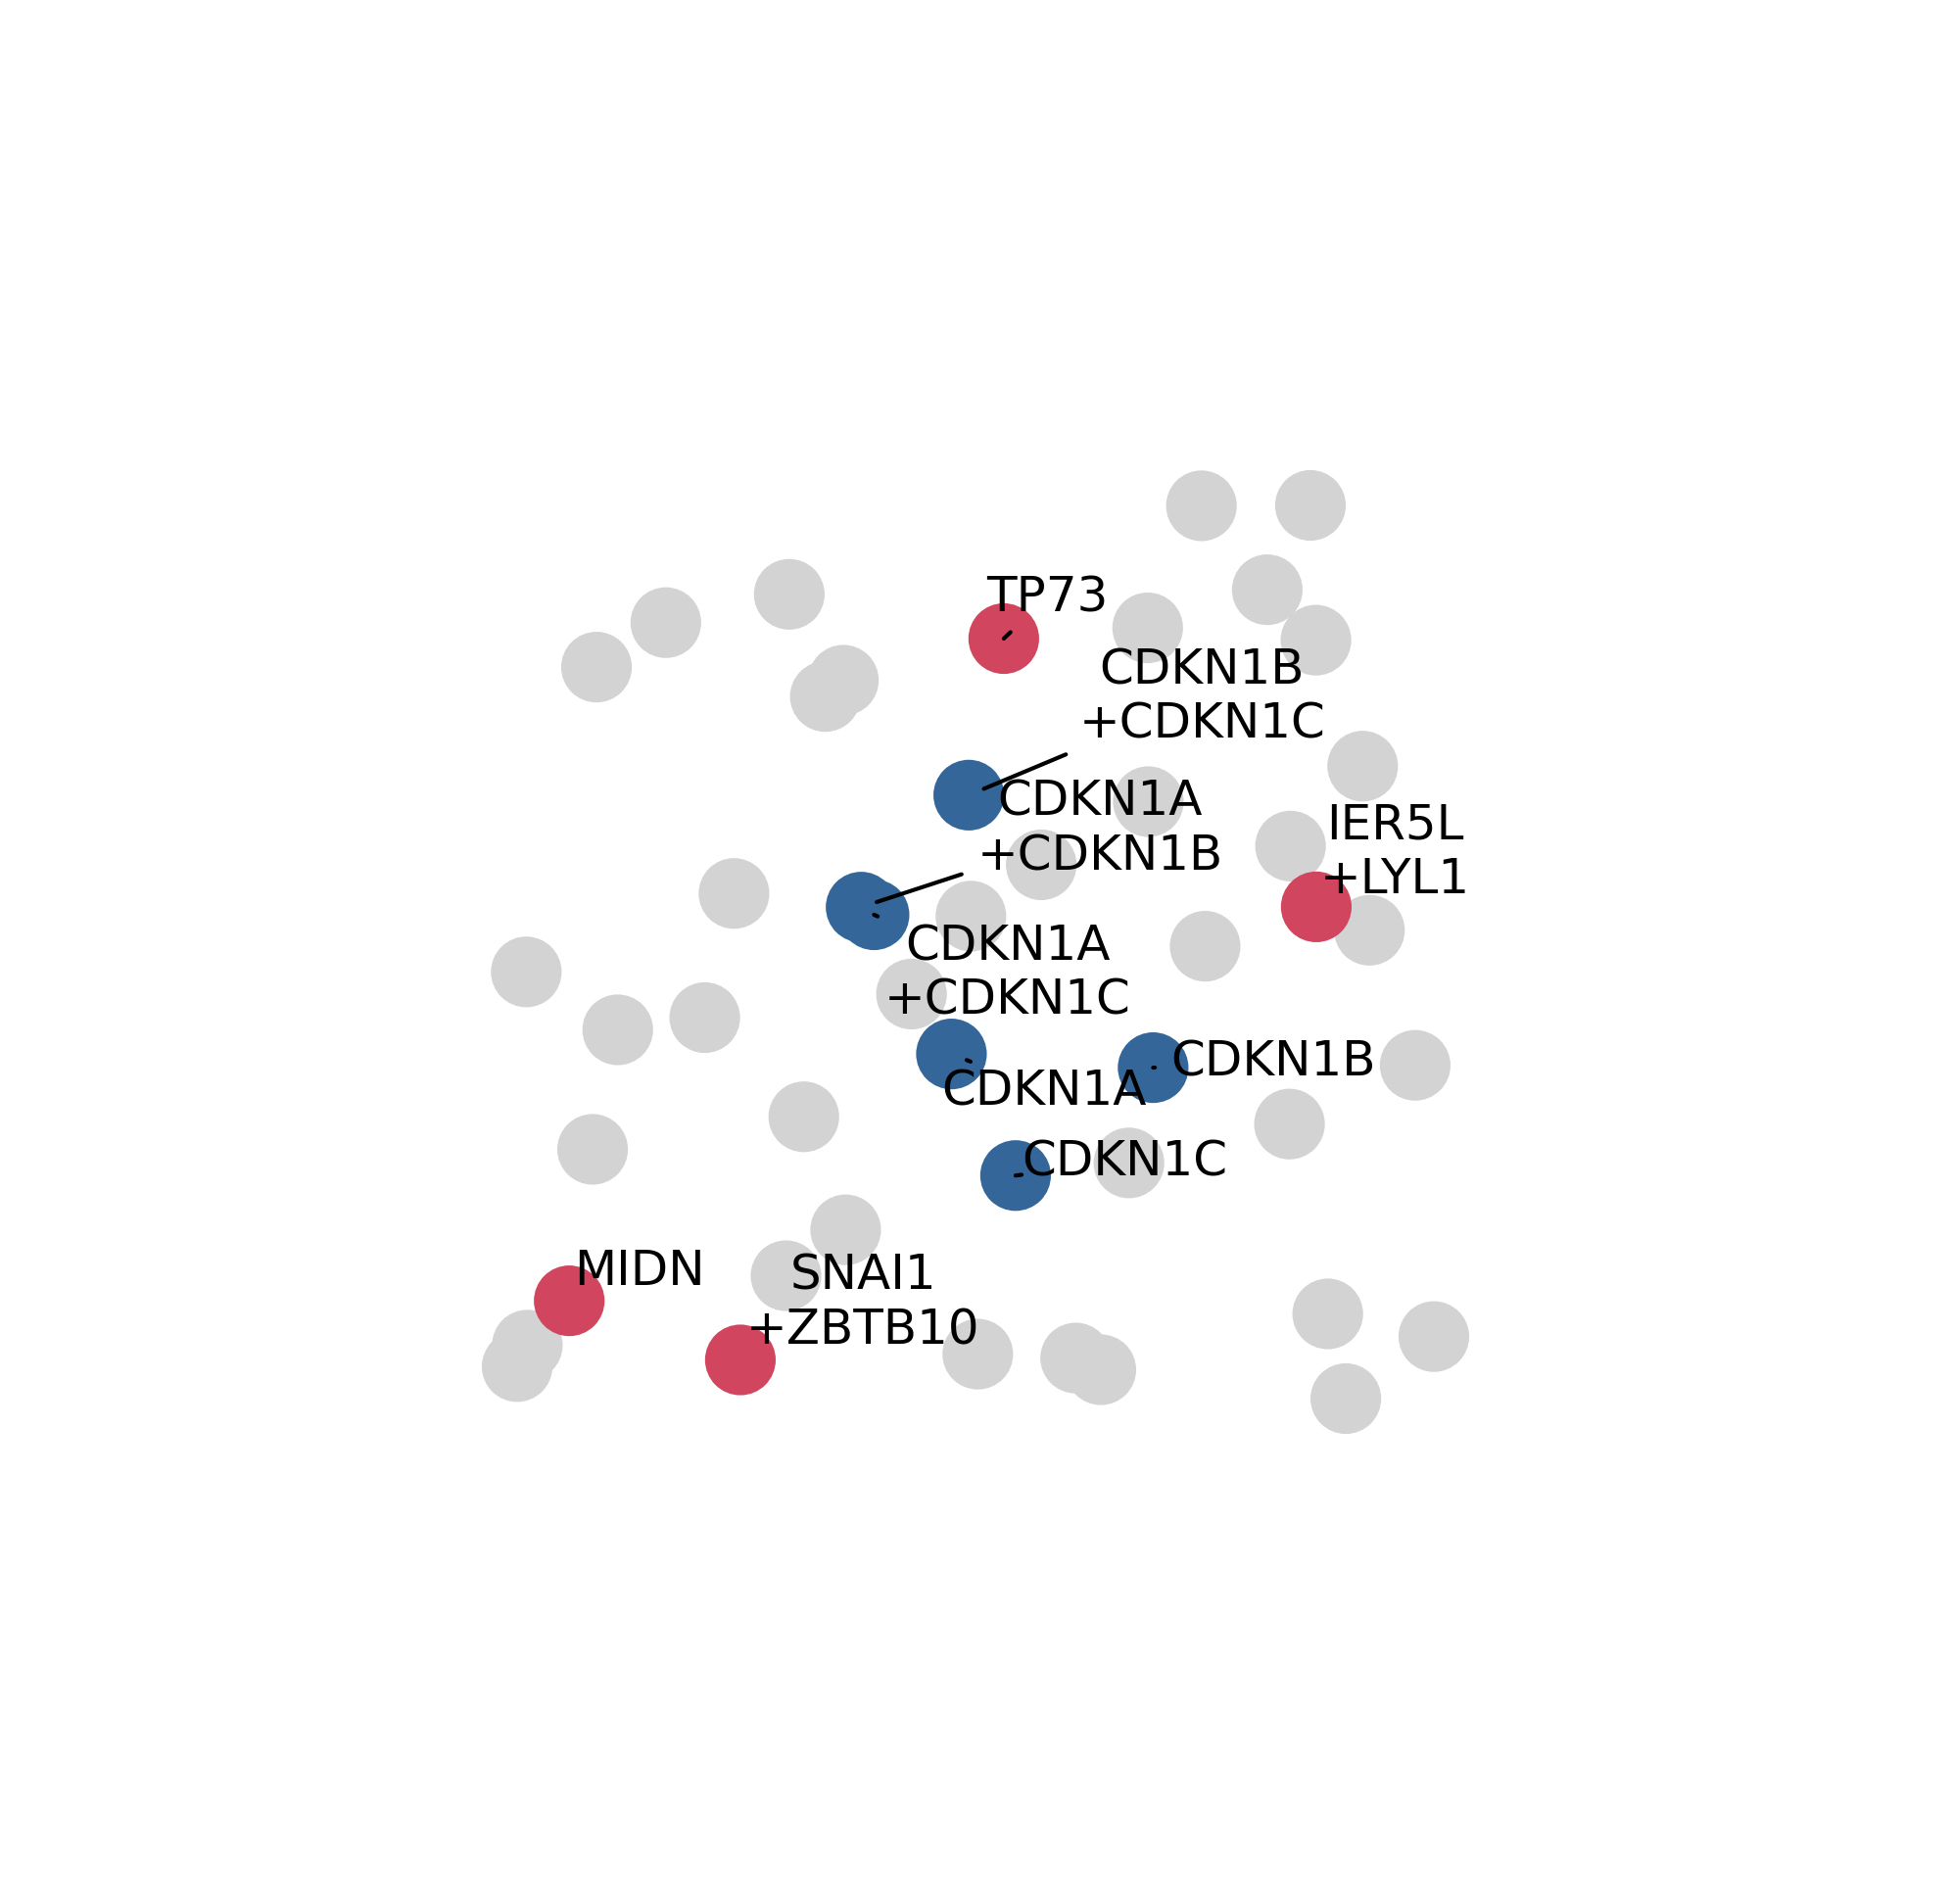

In [11]:
cell_cycle_umap = psadata_classifier[(psadata_classifier.obsm["X_umap"][:, 0] > 3) 
                                  & (psadata_classifier.obsm["X_umap"][:, 0] < 6)
                                  & (psadata_classifier.obsm["X_umap"][:, 1] > -3)
                                  & (psadata_classifier.obsm["X_umap"][:, 1] < -0.25)]

fig, ax = plt.subplots(figsize=(4, 4))
ax.margins(0.5)
sc.pl.umap(cell_cycle_umap[cell_cycle_umap.obs["gene_programme"] == "Unknown"], 
           color="gene_programme", 
           show=False, 
           size=300, 
           ax=ax, 
           title = "",
           palette=common_config.norman_gene_program_color_map)

annotated = cell_cycle_umap[cell_cycle_umap.obs["gene_programme"] != "Unknown"]
sc.pl.umap(annotated, 
           color="gene_programme", 
           show=False,
           size=300, 
           ax=ax, 
           title = "",
           palette=common_config.norman_gene_program_color_map)

texts = [ax.text(x, y, pert.replace('+','\n+'), fontsize=6) for x, y, pert in zip(annotated.obsm["X_umap"][:, 0], annotated.obsm["X_umap"][:, 1], annotated.obs["perturbation_name"])]
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

ax.get_legend().remove()
plt.savefig("norman/figures/discriminator_cell_cycle_UMAP.svg", bbox_inches="tight", format="svg")

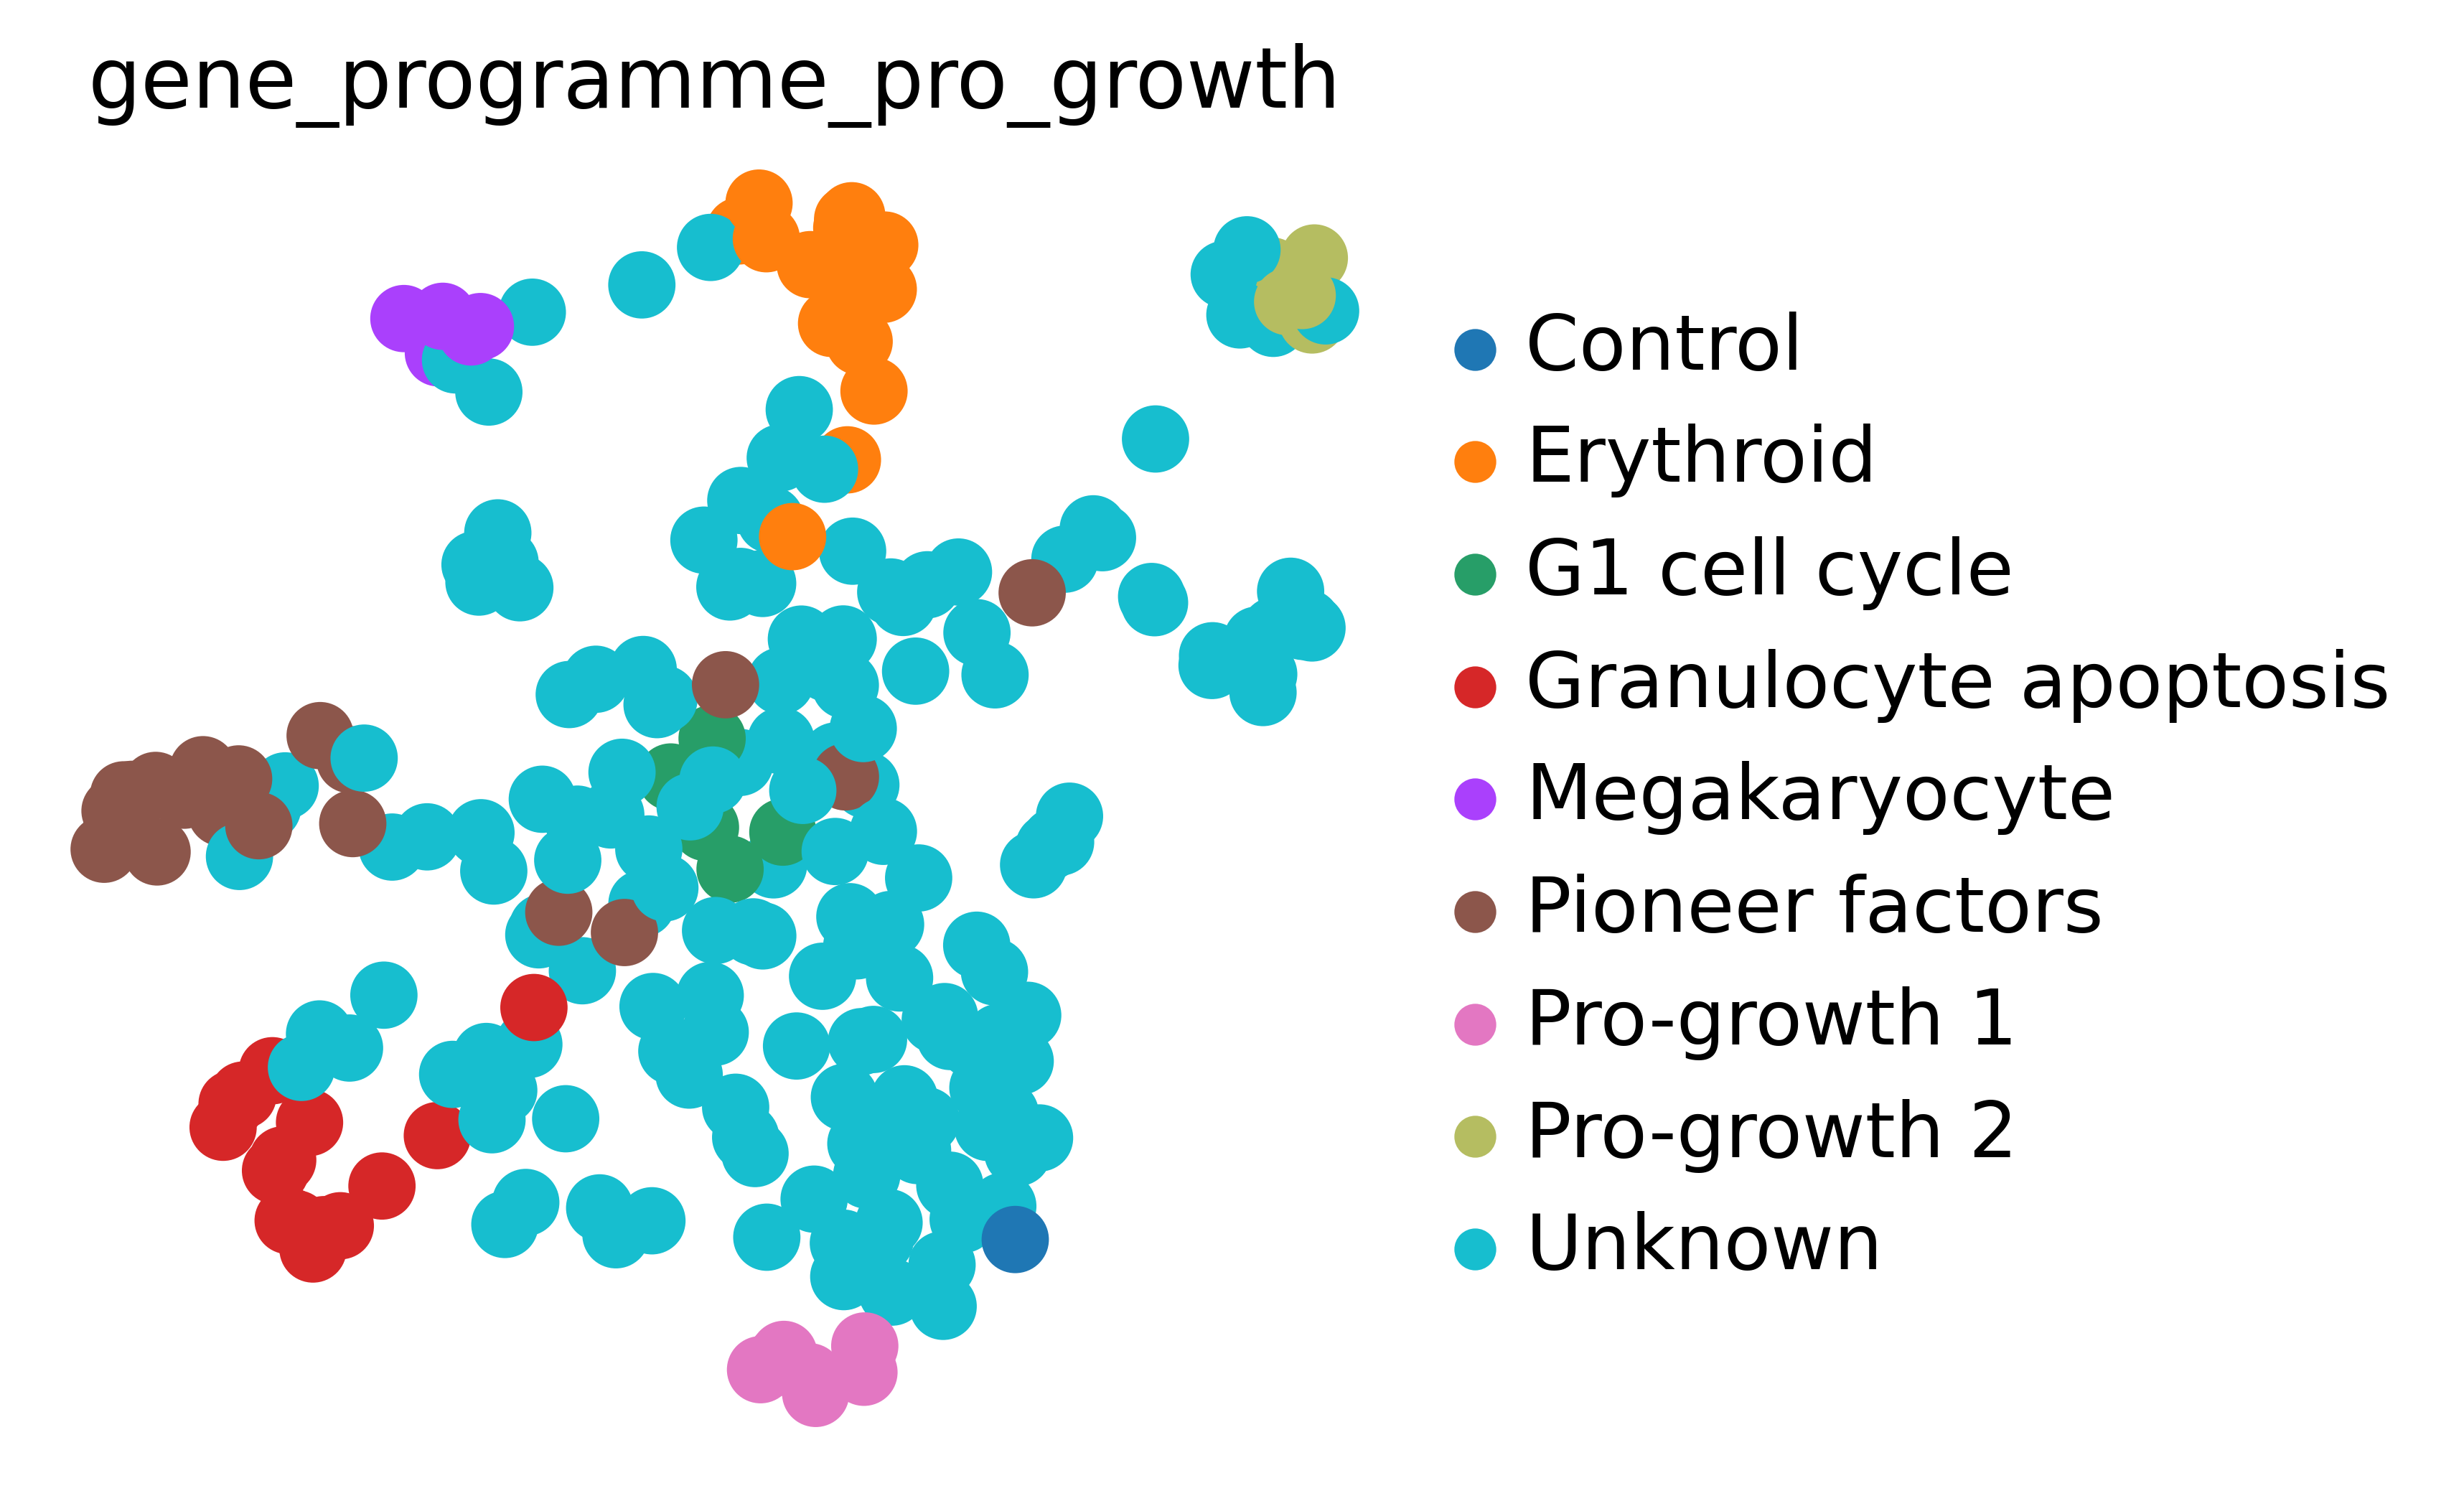

Output()

gene_programme_pro_growth,Unknown,Pro-growth 2,Erythroid,G1 cell cycle,Granulocyte apoptosis,Megakaryocyte,Pioneer factors,Pro-growth 1,Control
gene_programme_pro_growth,,,,,,,,,
Unknown,0.000000,0.383601,0.094414,0.011043,0.188577,0.266493,0.039596,0.122314,0.043476
Pro-growth 2,0.383601,0.000000,0.550397,0.416938,0.484296,0.690884,0.486040,0.455895,0.449762
Erythroid,0.094414,0.550397,0.000000,0.087987,0.321512,0.397779,0.142720,0.243739,0.163348
G1 cell cycle,0.011043,0.416938,0.087987,0.000000,0.213128,0.300433,0.042196,0.114359,0.039476
Granulocyte apoptosis,0.188577,0.484296,0.321512,0.213128,0.000000,0.346807,0.244945,0.322775,0.250915
Megakaryocyte,0.266493,0.690884,0.397779,0.300433,0.346807,0.000000,0.328222,0.424150,0.337827
Pioneer factors,0.039596,0.486040,0.142720,0.042196,0.244945,0.328222,0.000000,0.182800,0.092858
Pro-growth 1,0.122314,0.455895,0.243739,0.114359,0.322775,0.424150,0.182800,0.000000,0.124295
Control,0.043476,0.449762,0.163348,0.039476,0.250915,0.337827,0.092858,0.124295,0.000000


In [12]:
umap_y_coords = psadata_classifier.obsm["X_umap"][:, 1]
gene_programmes = psadata_classifier.obs["gene_programme"]

pro_growth_labels = []
for i, y_coord in enumerate(umap_y_coords):
    if gene_programmes[i] != "Pro-growth":
        pro_growth_labels.append(gene_programmes[i])
    elif y_coord < -3:
        pro_growth_labels.append("Pro-growth 1")
    else:
        pro_growth_labels.append("Pro-growth 2")
        
psadata_classifier.obs["gene_programme_pro_growth"] = pro_growth_labels
sc.pl.umap(psadata_classifier, color="gene_programme_pro_growth")

# Compute distance based on MLPClassifier embeddings
psadata_classifier.layers["X"] = psadata_classifier.X

# Pairwise MSE Distance between all gene programmes
Distance = pt.tools.Distance(metric="mse", layer_key="X")
pairwise_df = Distance.pairwise(psadata_classifier, groupby="gene_programme_pro_growth")
pairwise_df

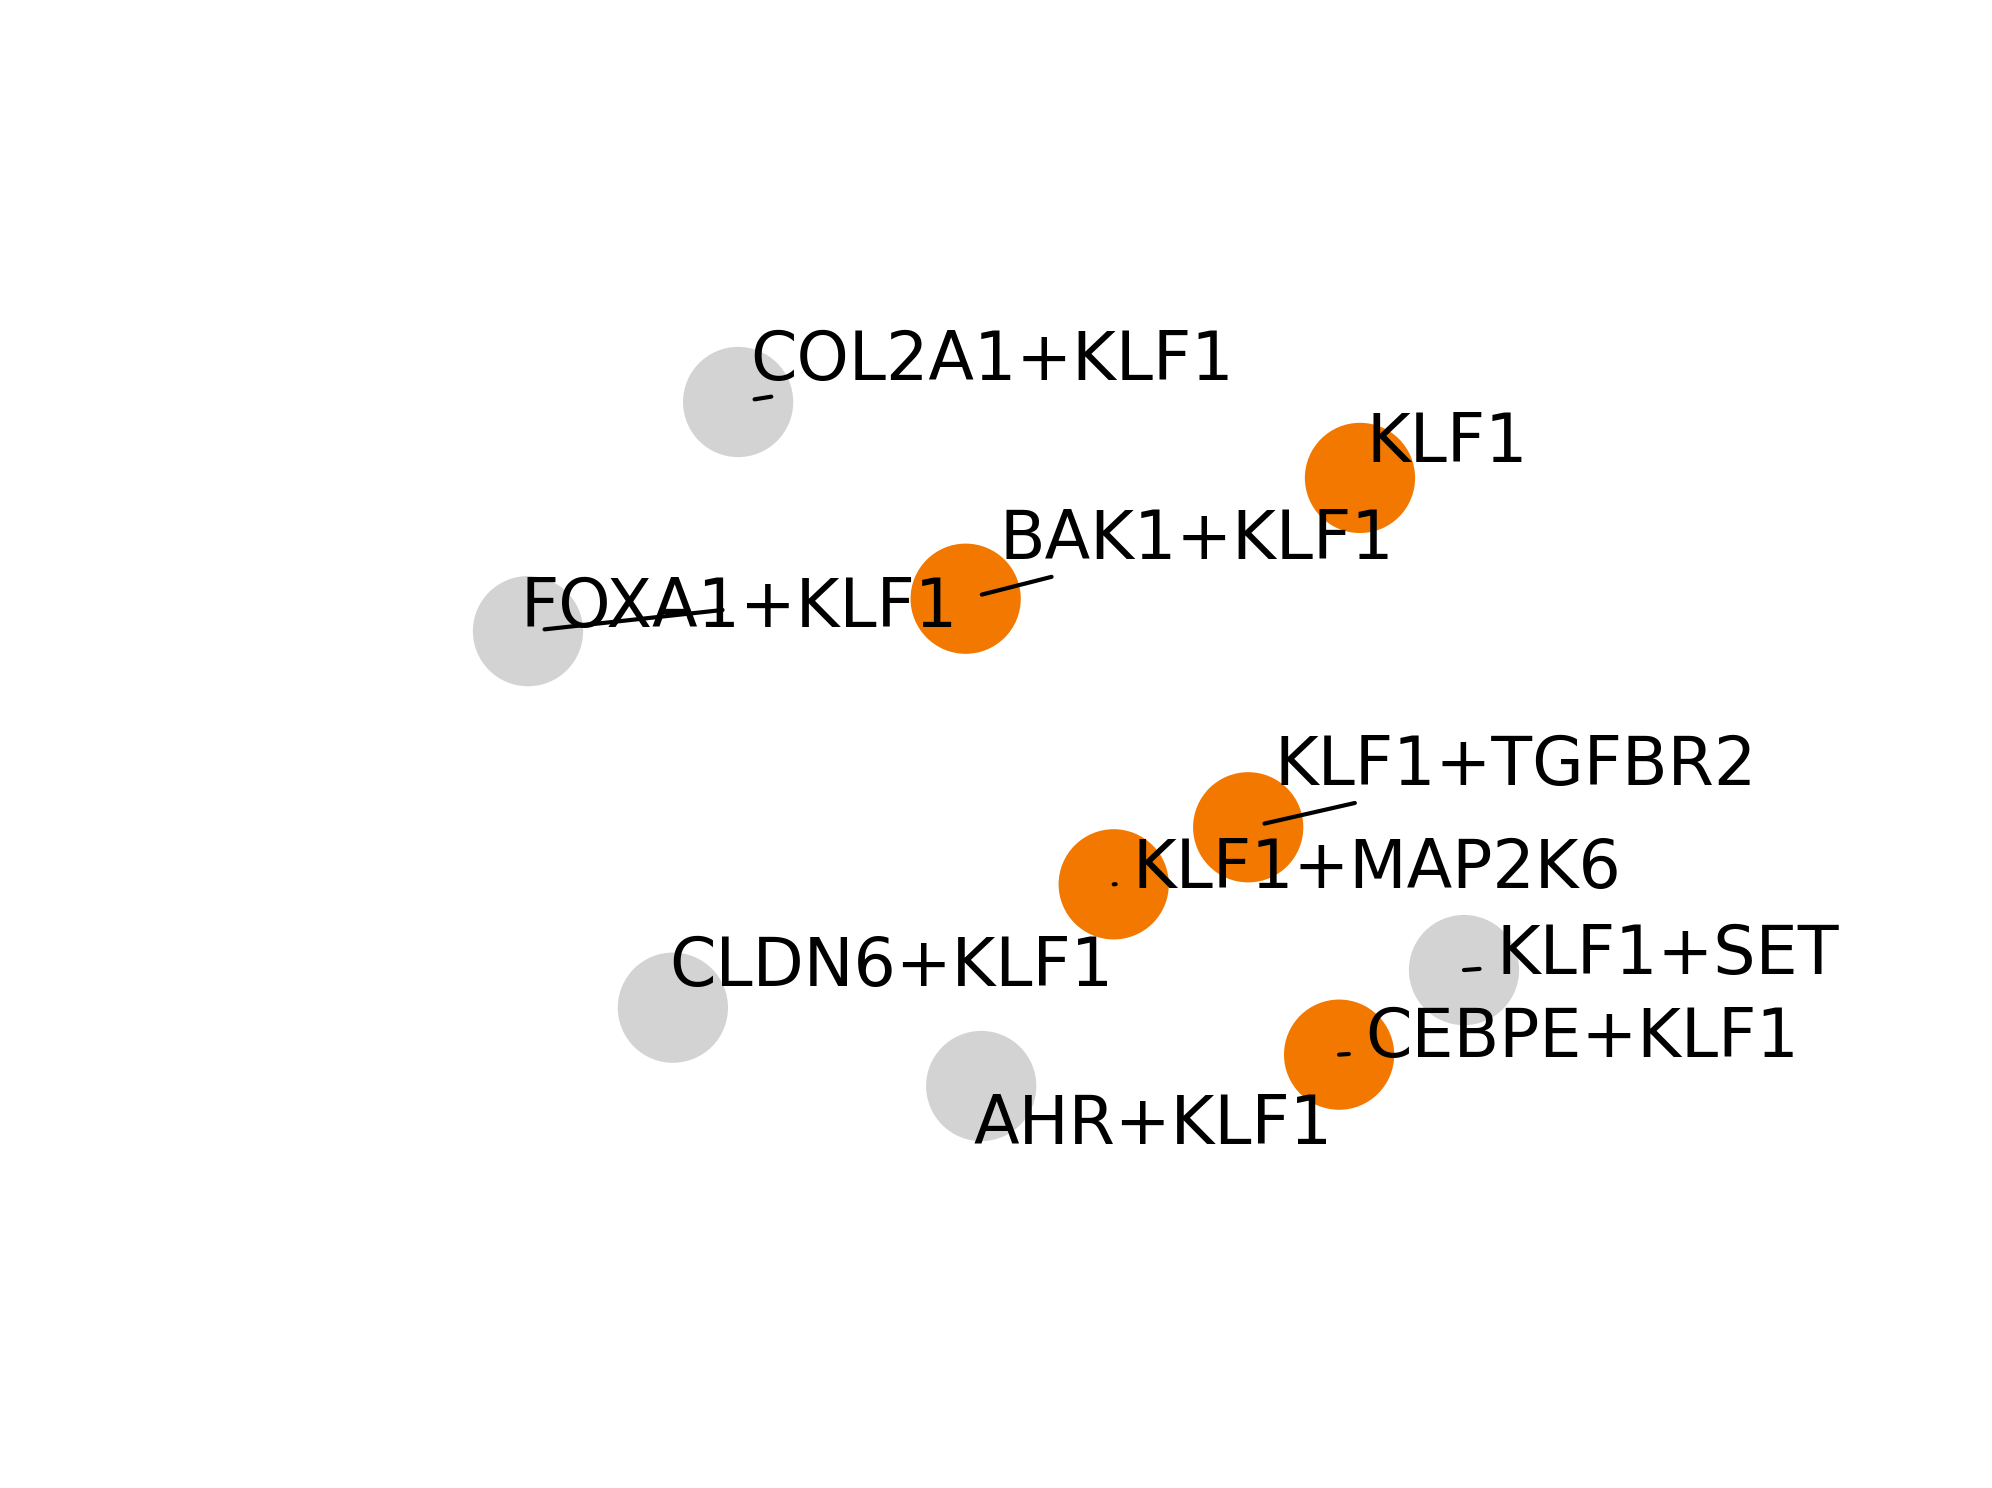

In [13]:
pro_growth1 = psadata_classifier[(psadata_classifier.obsm["X_umap"][:, 1] > 1.5)
                                & (psadata_classifier.obsm["X_umap"][:, 0] > 8)]

fig, ax = plt.subplots(figsize=(4, 3))
ax.margins(0.5)

sc.pl.umap(pro_growth1, 
           color="gene_programme", 
           show=False,
           size=700, 
           ax=ax, 
           title = "",
           palette=common_config.norman_gene_program_color_map
           )

texts = [ax.text(x, y, pert, fontsize=8) for x, y, pert in zip(pro_growth1.obsm["X_umap"][:, 0], pro_growth1.obsm["X_umap"][:, 1], pro_growth1.obs["perturbation_name"])]
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

ax.get_legend().remove()
plt.savefig("norman/figures/discriminator_pro_growth1_UMAP.svg", bbox_inches="tight", format="svg")

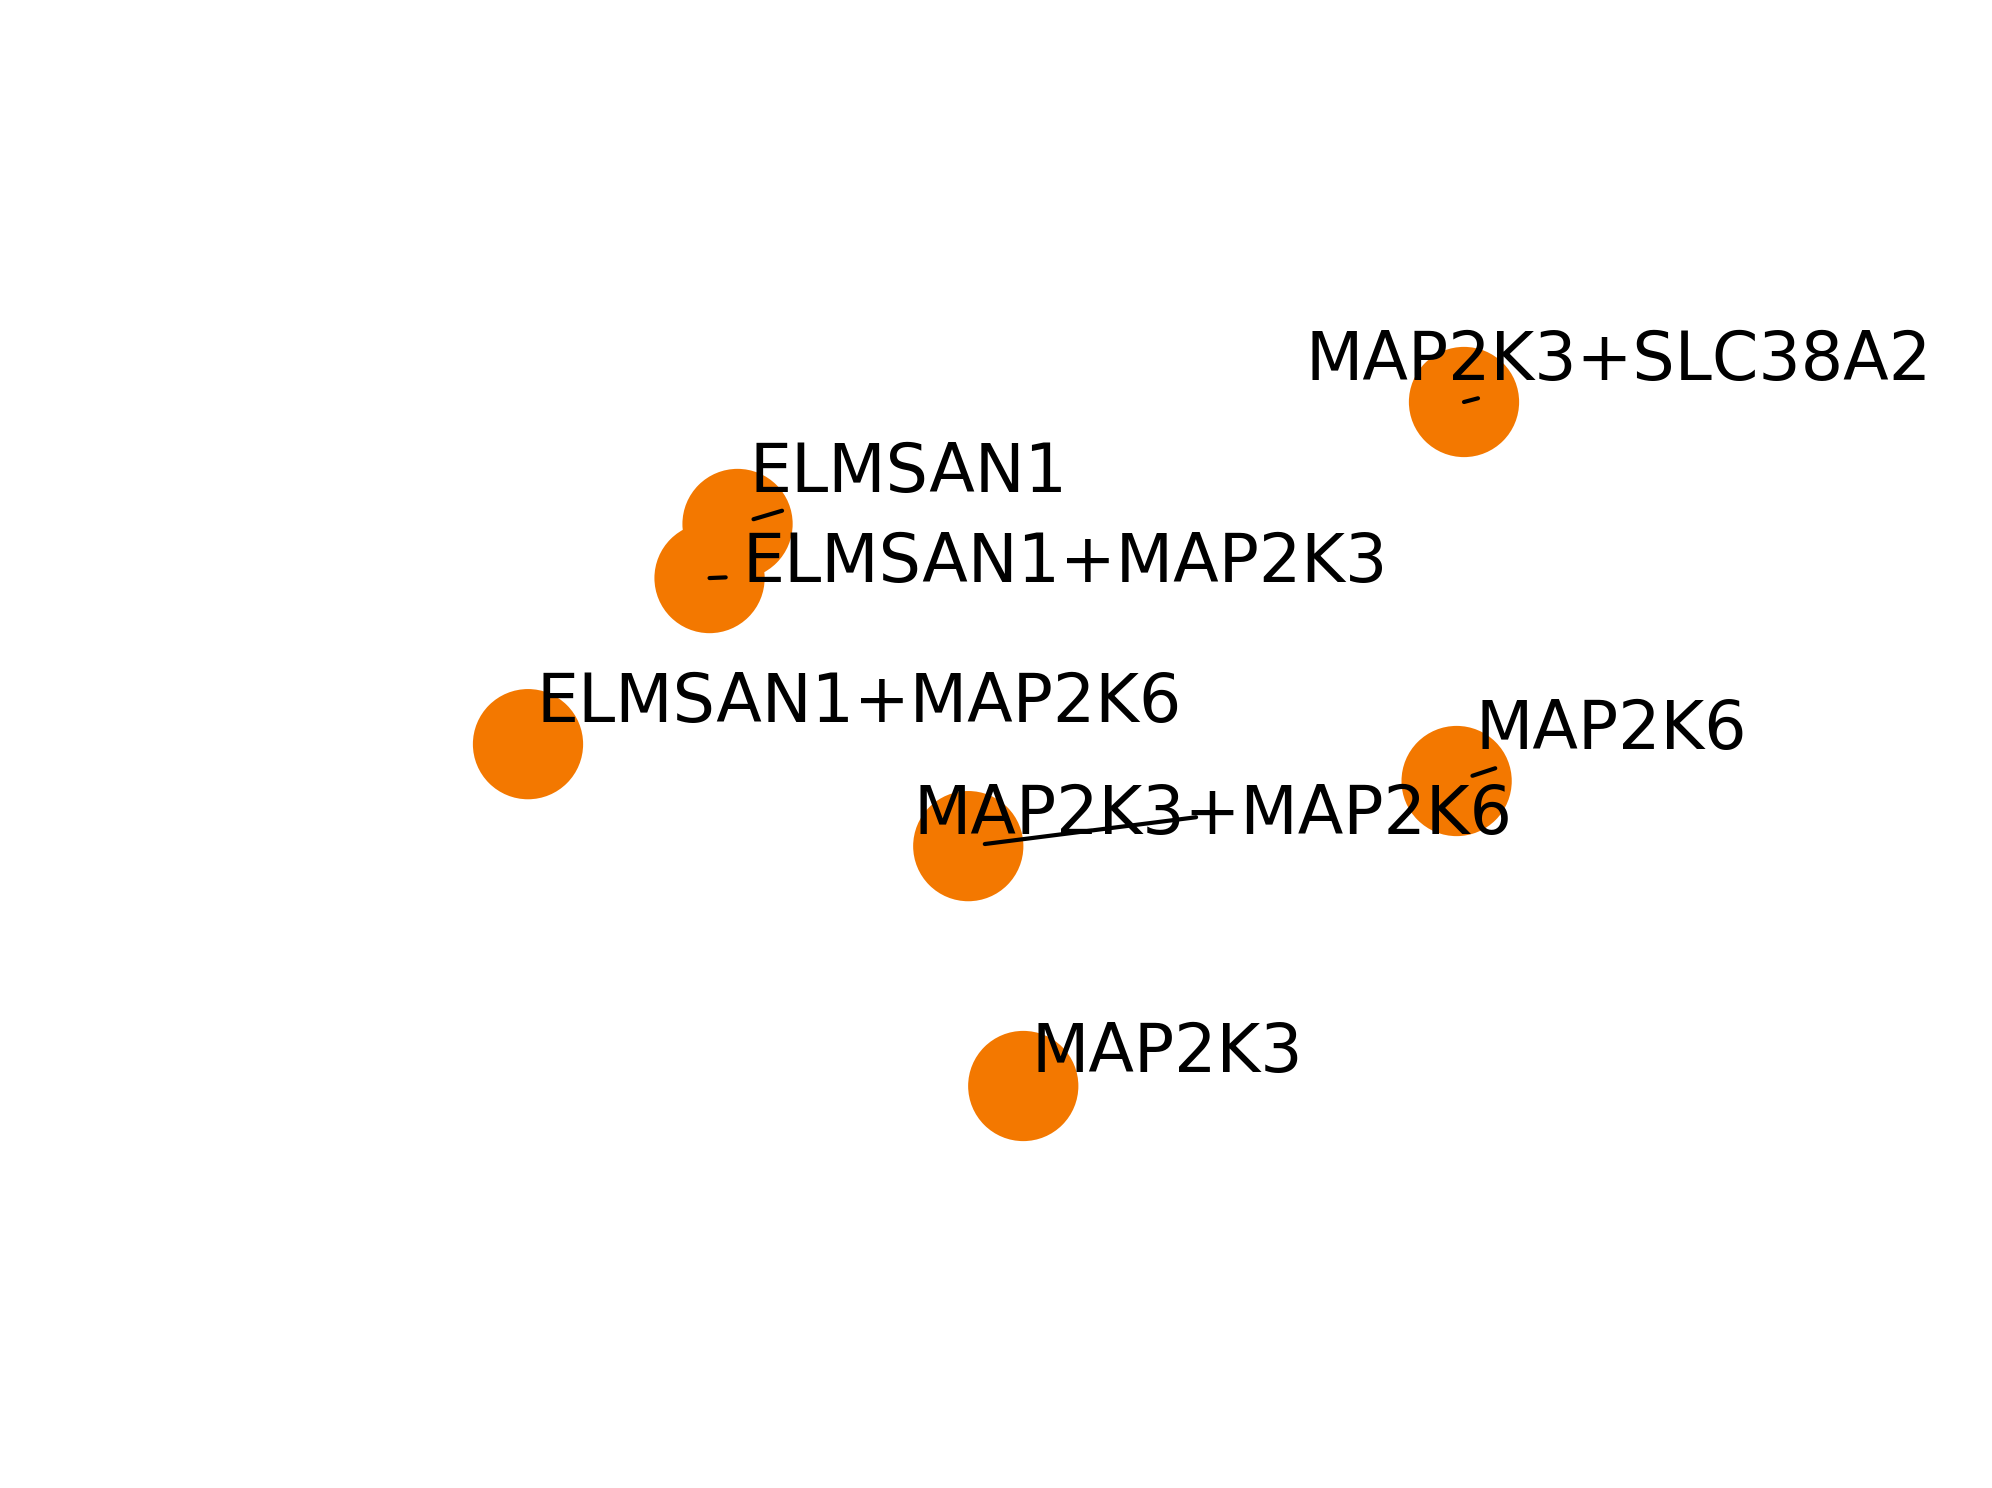

In [13]:
pro_growth2 = psadata_classifier[(psadata_classifier.obsm["X_umap"][:, 1] < -6)
                                & (psadata_classifier.obsm["X_umap"][:, 0] > 1)]
                                #& (psadata_classifier.obs["gene_programme"] == "Pro-growth")]

fig, ax = plt.subplots(figsize=(4, 3))
ax.margins(0.5)

#annotated = pro_growth1[pro_growth1.obs["gene_programme"] != "Unknown"]
sc.pl.umap(pro_growth2, 
           color="gene_programme", 
           show=False,
           size=700, 
           ax=ax, 
           title = "",
           palette=common_config.norman_gene_program_color_map
           )

texts = [ax.text(x, y, pert, fontsize=8) for x, y, pert in zip(pro_growth2.obsm["X_umap"][:, 0], pro_growth2.obsm["X_umap"][:, 1], pro_growth2.obs["perturbation_name"])]
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

ax.get_legend().remove()
plt.savefig("norman/figures/discriminator_pro_growth2_UMAP.pdf", bbox_inches="tight", format="pdf")

## Identification and analysis of an unknown cluster

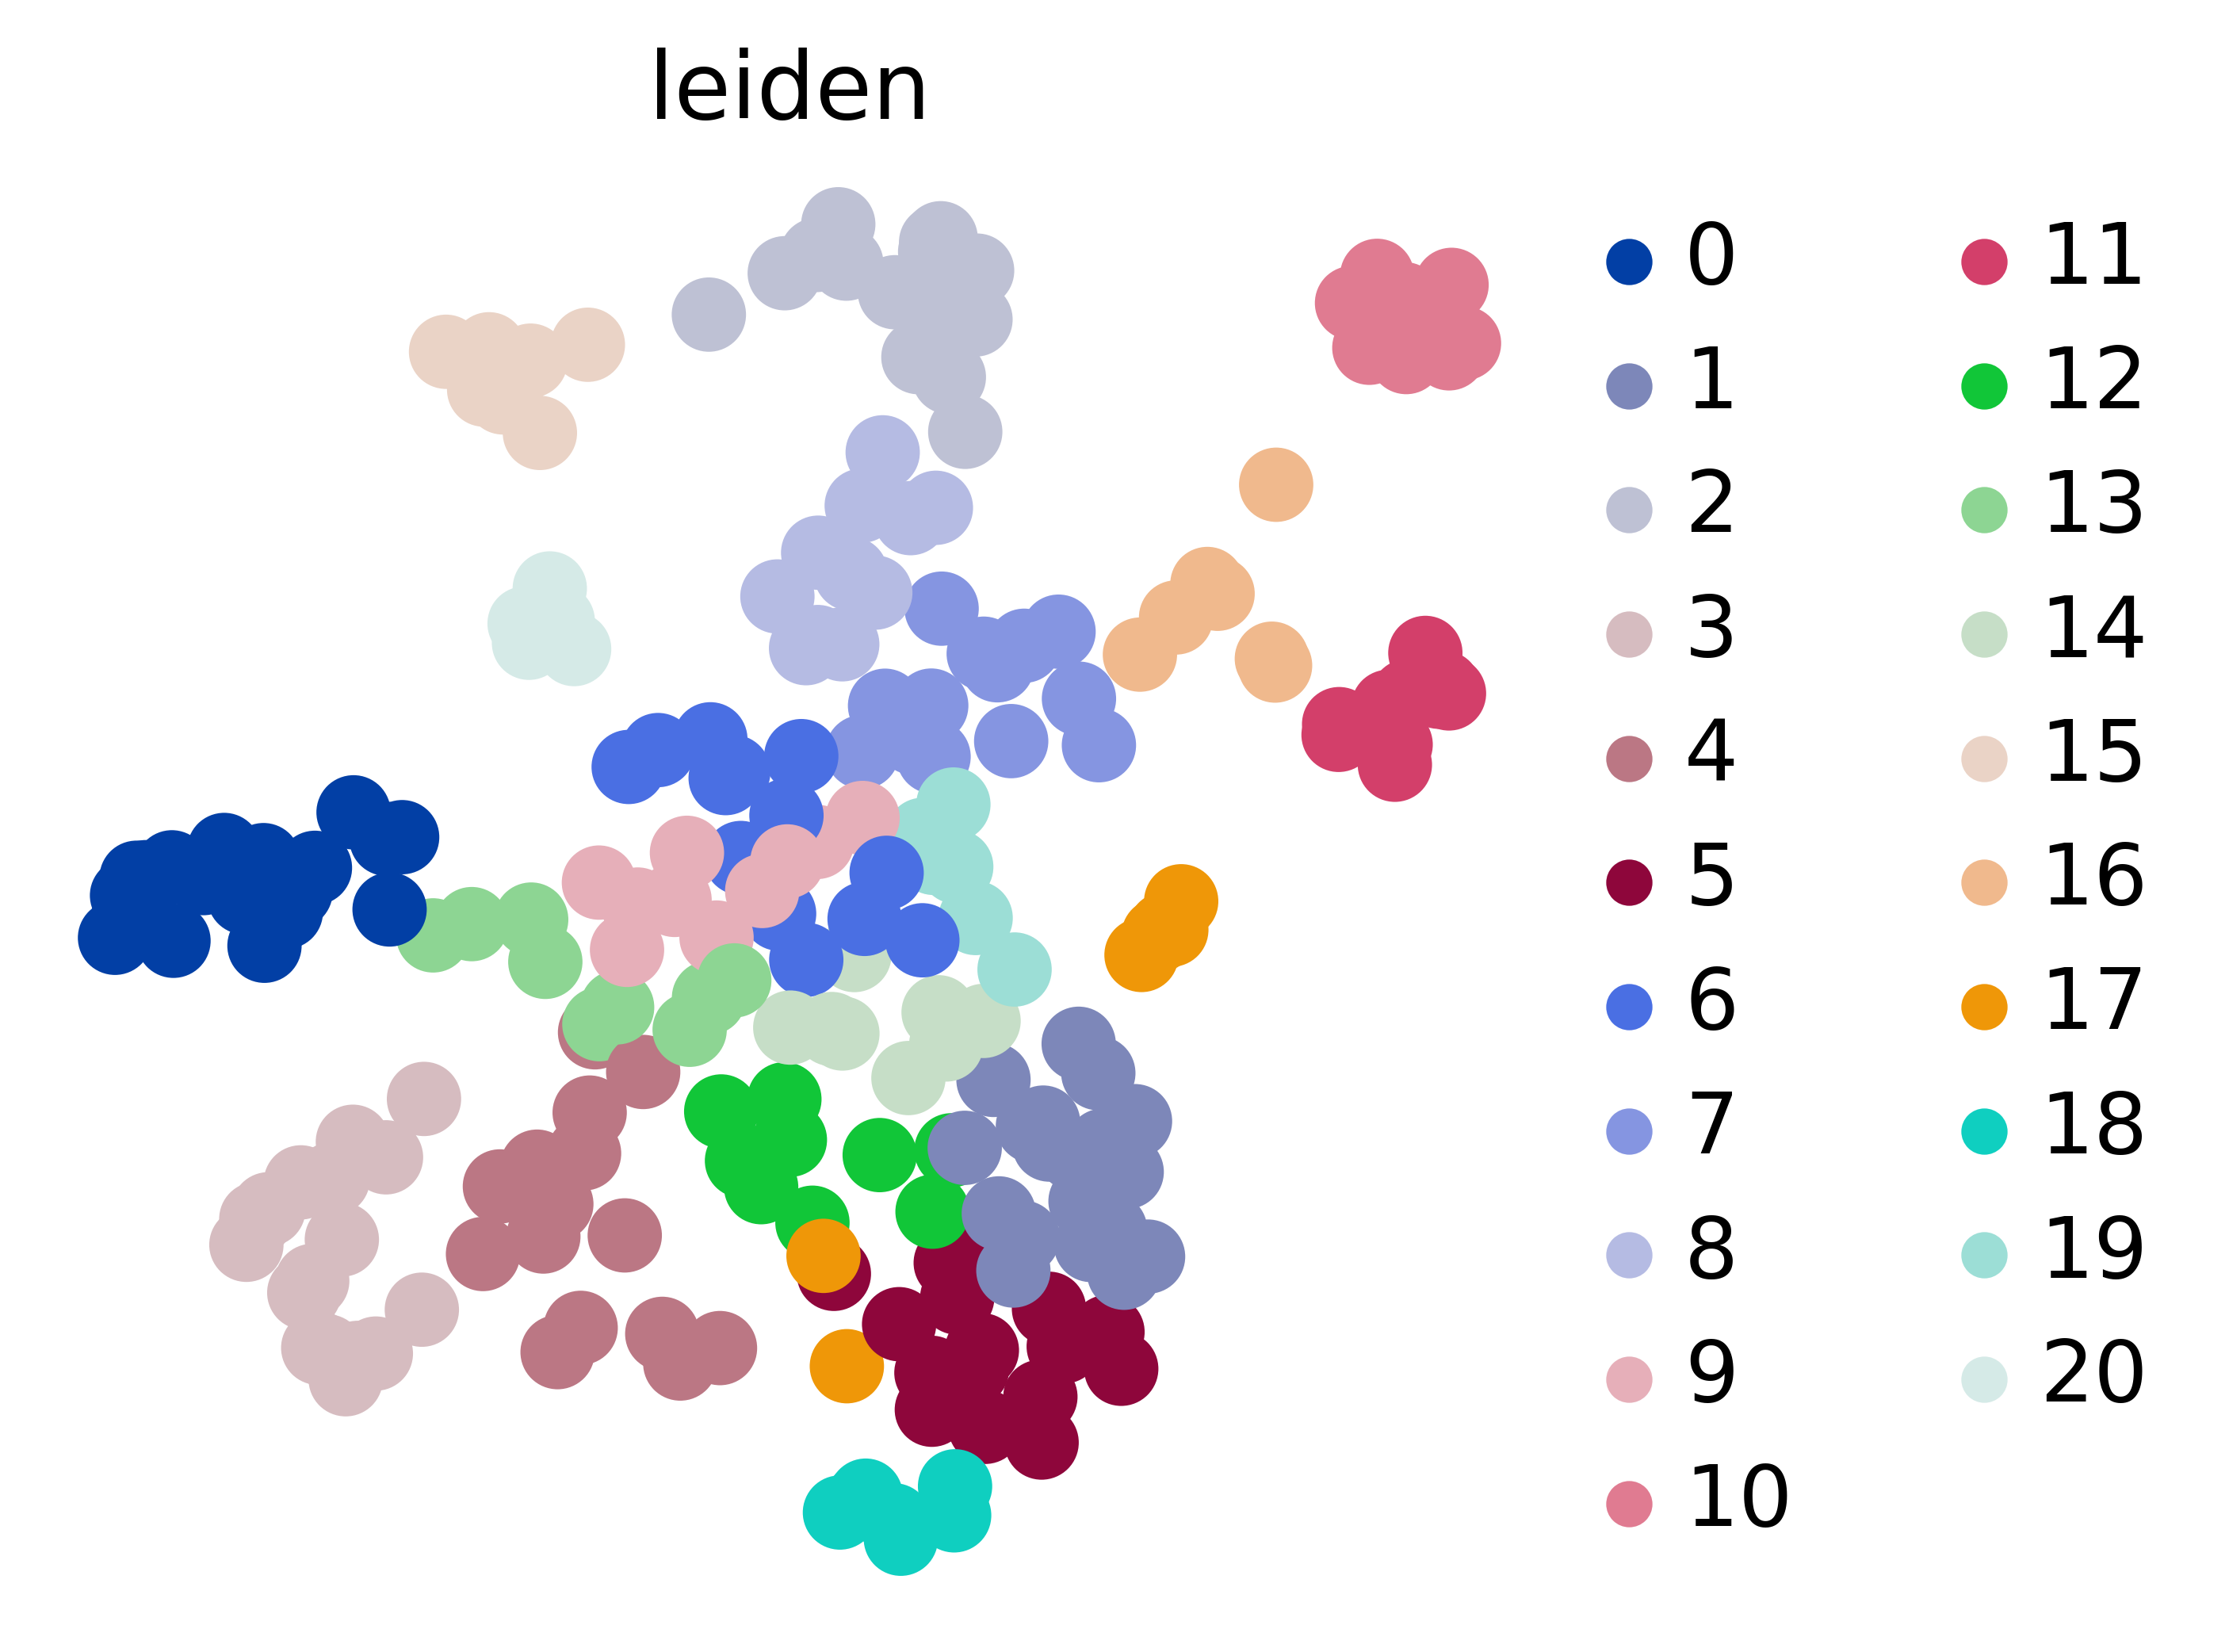

In [14]:
sc.tl.leiden(psadata_classifier, resolution=3)
sc.pl.umap(psadata_classifier, color="leiden")

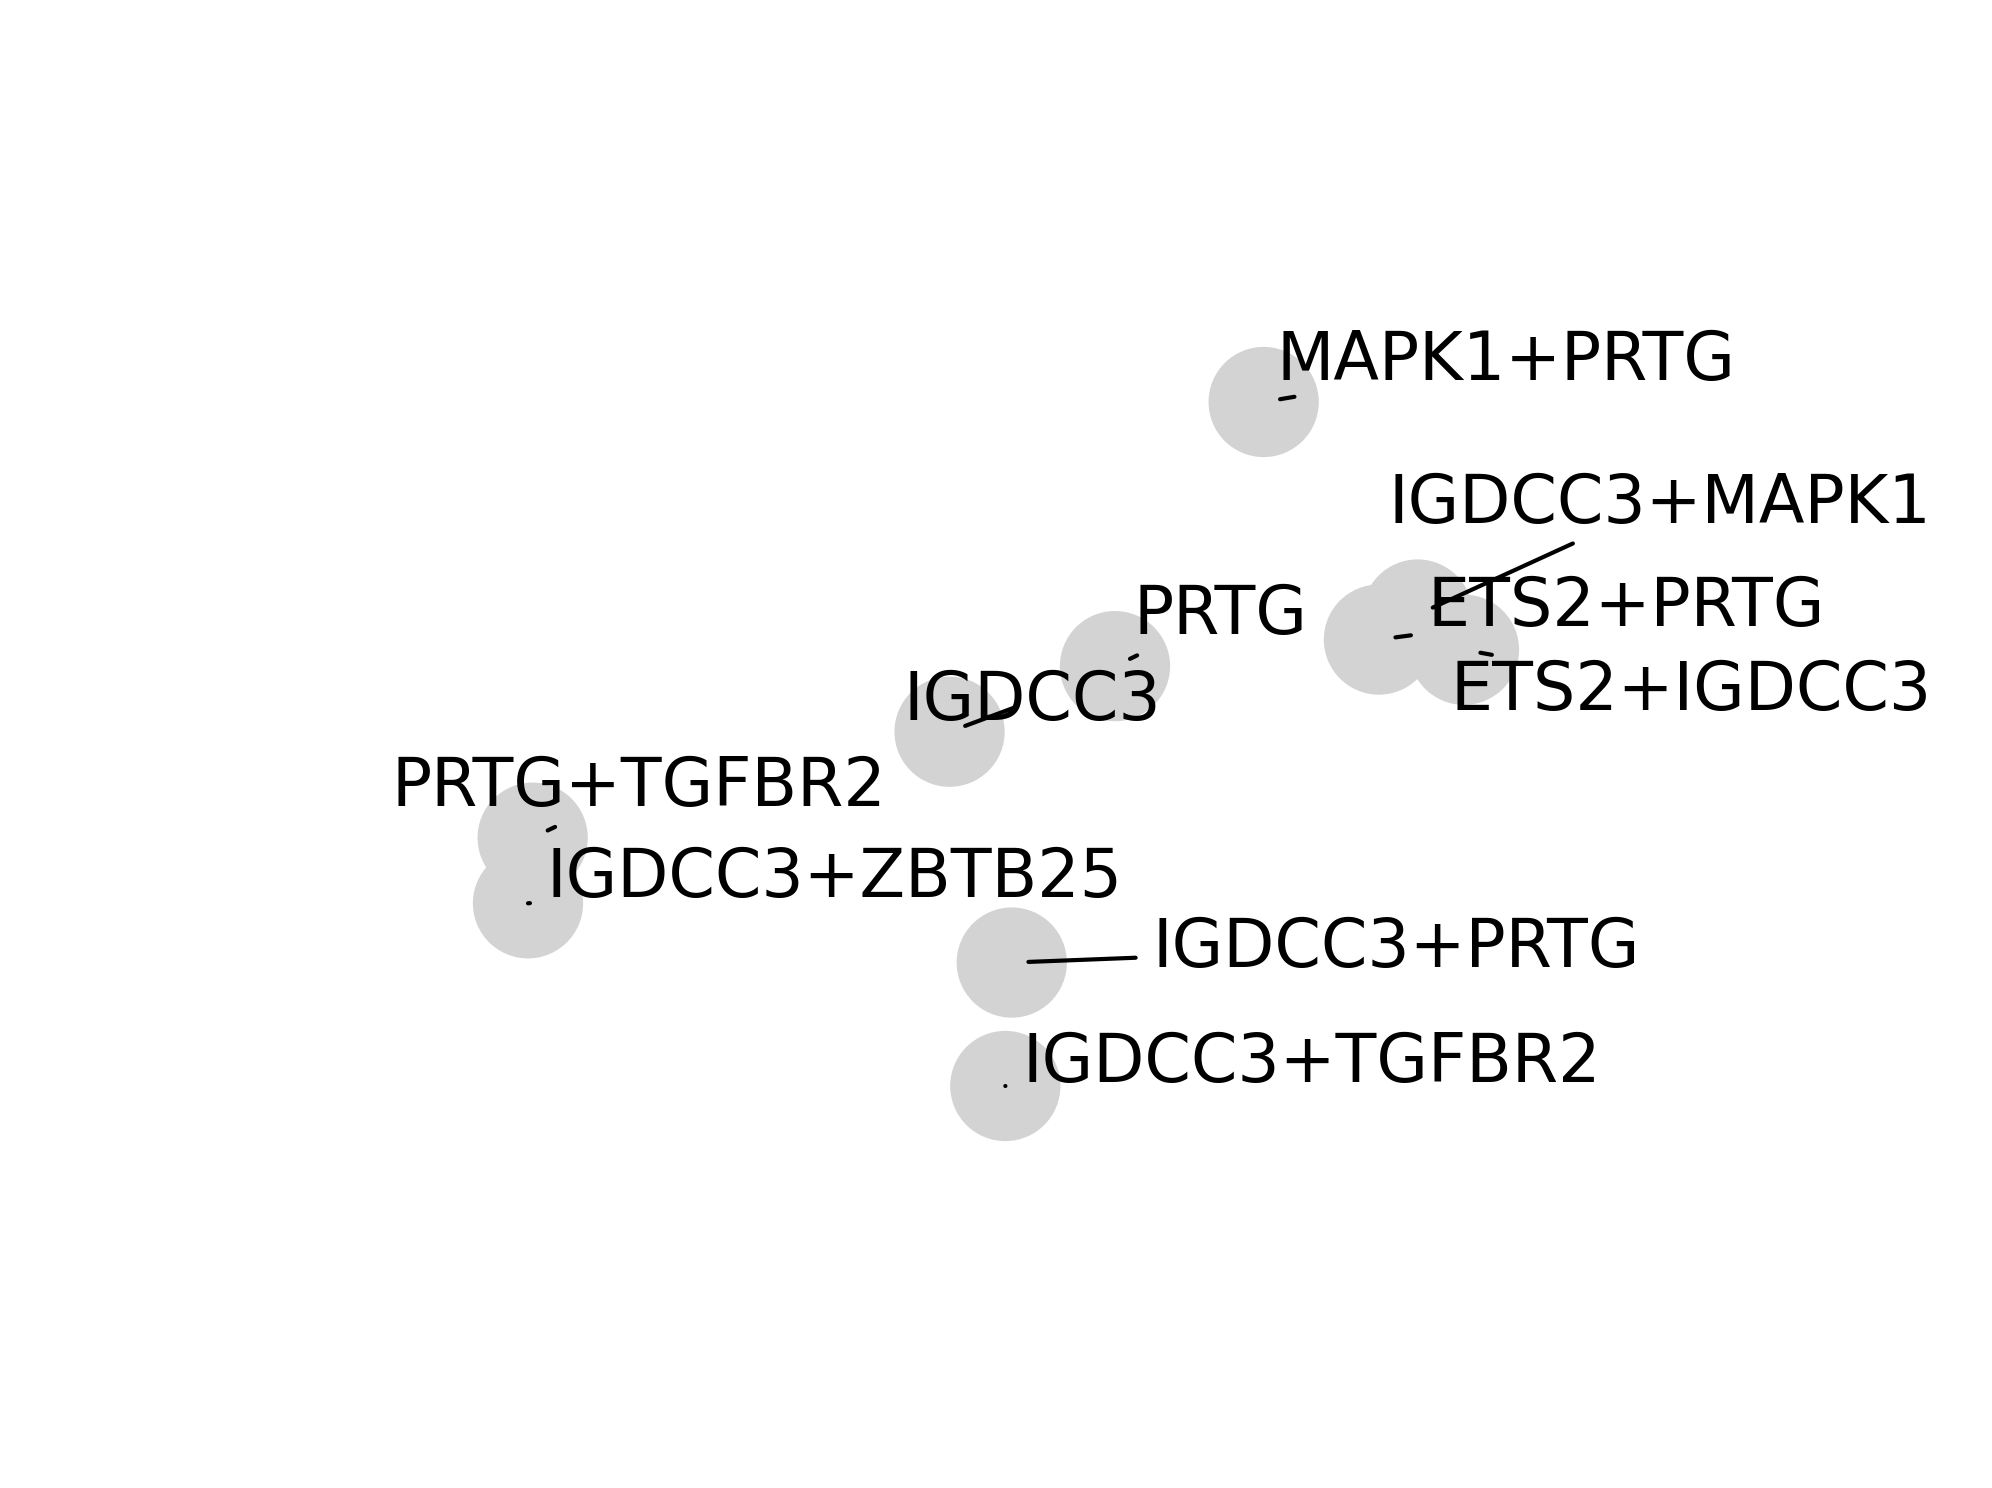

In [15]:
#TODO: Cluse-up UMAP of cluster of interest
coi = psadata_classifier[(psadata_classifier.obsm["X_umap"][:, 1] > -2)
                                & (psadata_classifier.obsm["X_umap"][:, 0] > 8)
                                & (psadata_classifier.obsm["X_umap"][:, 1] < 2)]
                                #& (psadata_classifier.obs["gene_programme"] == "Pro-growth")]

fig, ax = plt.subplots(figsize=(4, 3))
ax.margins(0.5)

#annotated = pro_growth1[pro_growth1.obs["gene_programme"] != "Unknown"]
sc.pl.umap(coi, 
           color="gene_programme", 
           show=False,
           size=700, 
           ax=ax, 
           title = "",
           palette=common_config.norman_gene_program_color_map
           )

texts = [ax.text(x, y, pert, fontsize=8) for x, y, pert in zip(coi.obsm["X_umap"][:, 0], coi.obsm["X_umap"][:, 1], coi.obs["perturbation_name"])]
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

ax.get_legend().remove()
plt.savefig("norman/figures/discriminator_coi_UMAP.pdf", bbox_inches="tight", format="pdf")

In [16]:
unknown_cluster = psadata_classifier[psadata_classifier.obs["leiden"] == "11"]
unknown_perts = unknown_cluster.obs["perturbation_name"].unique()

adata.obs["Cluster of Interest"] = ["To determine" if pert in unknown_perts else "Not in cluster" for pert in adata.obs["perturbation_name"]]

sc.tl.rank_genes_groups(adata, groupby="Cluster of Interest")

In [17]:
# GSEA for genes that are UPREGULATED in the cluster of interest
enrichment_up = sc.queries.enrich(adata, "To determine", pval_cutoff=0.01, log2fc_min=0)
enrichment_up = enrichment_up[enrichment_up["source"] == "REAC"]
enrichment_up.to_csv("norman/output/reactome_enrichment_up.csv")
enrichment_up.head()

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
18,REAC,REAC:R-HSA-156827,L13a-mediated translational silencing of Cerul...,1.886606e-07,True,L13a-mediated translational silencing of Cerul...,112,244,17,10916,0.069672,0.151786,query_1,[REAC:R-HSA-72613]
19,REAC,REAC:R-HSA-72706,GTP hydrolysis and joining of the 60S ribosoma...,2.176937e-07,True,GTP hydrolysis and joining of the 60S ribosoma...,113,244,17,10916,0.069672,0.150442,query_1,[REAC:R-HSA-72737]
24,REAC,REAC:R-HSA-72737,Cap-dependent Translation Initiation,5.686039e-07,True,Cap-dependent Translation Initiation,120,244,17,10916,0.069672,0.141667,query_1,[REAC:R-HSA-72613]
25,REAC,REAC:R-HSA-72613,Eukaryotic Translation Initiation,5.686039e-07,True,Eukaryotic Translation Initiation,120,244,17,10916,0.069672,0.141667,query_1,[REAC:R-HSA-72766]
44,REAC,REAC:R-HSA-156902,Peptide chain elongation,4.996646e-06,True,Peptide chain elongation,90,244,14,10916,0.057377,0.155556,query_1,[REAC:R-HSA-156842]


In [18]:
# GSEA for genes that are DOWNREGULATED in the cluster of interest
enrichment_down = sc.queries.enrich(adata, "To determine", pval_cutoff=0.01, log2fc_max=0)
enrichment_down = enrichment_down[enrichment_down["source"] == "REAC"]
enrichment_down.to_csv("norman/output/reactome_enrichment_down.csv")
enrichment_down.head()

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
11,REAC,REAC:R-HSA-6798695,Neutrophil degranulation,3.461883e-26,True,Neutrophil degranulation,476,485,84,10916,0.173196,0.176471,query_1,[REAC:R-HSA-168249]
20,REAC,REAC:R-HSA-168249,Innate Immune System,5.626260e-18,True,Innate Immune System,1099,485,118,10916,0.243299,0.107370,query_1,[REAC:R-HSA-168256]
51,REAC,REAC:R-HSA-168256,Immune System,5.402252e-13,True,Immune System,2079,485,165,10916,0.340206,0.079365,query_1,[REAC:0000000]
331,REAC,REAC:R-HSA-9755511,KEAP1-NFE2L2 pathway,1.211143e-03,True,KEAP1-NFE2L2 pathway,124,485,19,10916,0.039175,0.153226,query_1,[REAC:R-HSA-9711123]
360,REAC,REAC:R-HSA-9759194,Nuclear events mediated by NFE2L2,2.195337e-03,True,Nuclear events mediated by NFE2L2,95,485,16,10916,0.032990,0.168421,query_1,[REAC:R-HSA-9755511]


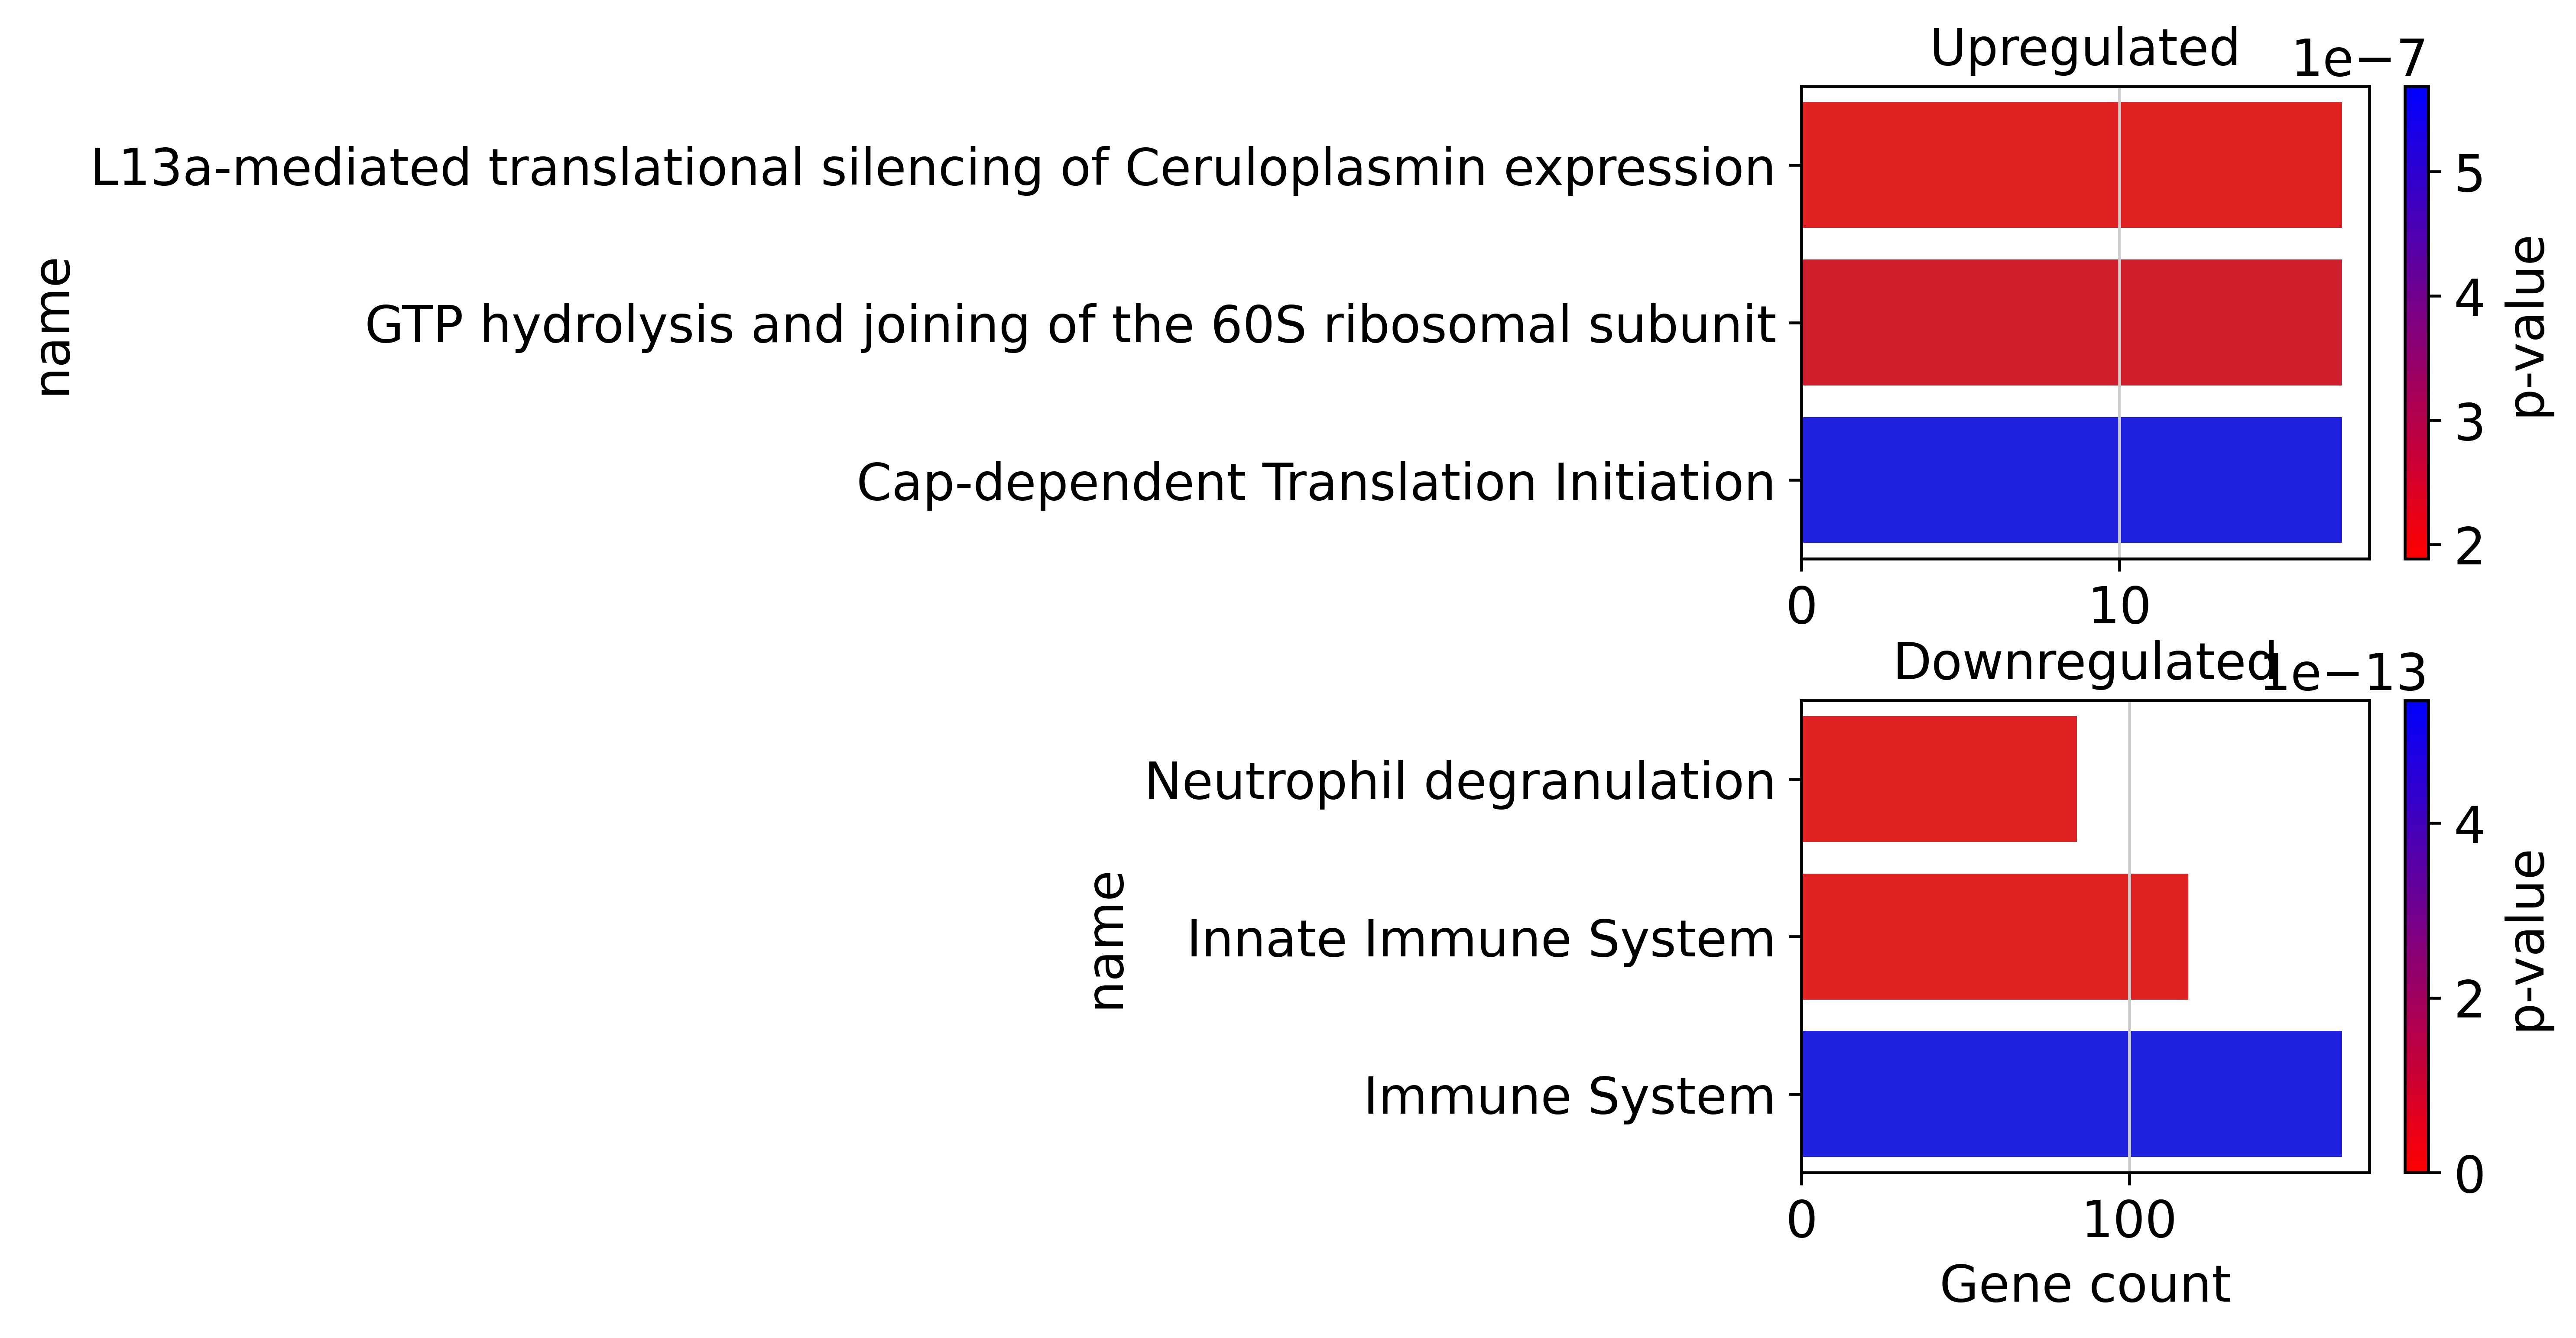

In [19]:
enrichment_up = enrichment_up.sort_values(by="p_value", ascending=True)[:3]
enrichment_down = enrichment_down.sort_values(by="p_value", ascending=True)[:3]

def make_cbar(values, cmap, ax):
    norm = plt.Normalize(vmin=values.min(), vmax=values.max())
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    ax.get_legend().remove()
    ax.figure.colorbar(sm, ax=ax, label="p-value")

try:
    matplotlib.colormaps.get_cmap("rb")
except ValueError:
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red", "blue"])
    matplotlib.colormaps.register(cmap, name="rb")

# Plot the GSEA results in two subplots
plt.subplots(2, 1, figsize=(3.5, 5.5))

plt.subplot(2, 1, 1)
enrichment_up = enrichment_up.sort_values(by="p_value")
sns.barplot(
    data=enrichment_up,
    x="intersection_size",
    y="name",
    hue="p_value",
    palette="rb",
)
make_cbar(enrichment_up["p_value"], "rb", plt.gca())
plt.title(f"Upregulated")
plt.xlabel("")


plt.subplot(2, 1, 2)
sns.barplot(
    data=enrichment_down,
    x="intersection_size",
    y="name",
    hue="p_value",
    palette="rb",
)
make_cbar(enrichment_down["p_value"], "rb", plt.gca())
plt.title(f"Downregulated")
plt.xlabel("Gene count")

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

plt.savefig("norman/figures/gsea_cluster_of_interest.pdf", bbox_inches="tight")